In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import segyio  # não sendo usada
import scipy.signal
import scipy.interpolate
import pylops
import seaborn as sns
import scipy.linalg
from numpy.linalg import inv
import warnings

warnings.filterwarnings("ignore")

sns.set_theme()

# Carregamento dos dados

In [2]:
# importação das superfícies
eoceno = pd.read_csv(
    "Superficies/EocenoSuperior_SubvolBackground_Time.dat",
    delim_whitespace=True,
    skiprows=0,
    usecols=(0, 1, 2),
    names=["X", "Y", "Z"],
)

paleoceno = pd.read_csv(
    "Superficies/Paleoceno_SubvolBackground_Time.dat",
    delim_whitespace=True,
    skiprows=0,
    usecols=(0, 1, 2),
    names=["X", "Y", "Z"],
)

# determinação dos limites
xl_start = np.min(eoceno["Y"])
xl_end = np.max(eoceno["Y"])

amp = np.load("Sismica/sismica_497.npy")
mback = np.load("Impedancia/lowfrequency_497.npy")  #
wav = np.load("Wavelets/wav_avg.npy")
print(f" amp shape {np.shape(amp)}")
print(f" mback shape {np.shape(mback)}")
print(f" wav shape {np.shape(wav)}")

 amp shape (1051, 1751)
 mback shape (1051, 1751)
 wav shape (30,)


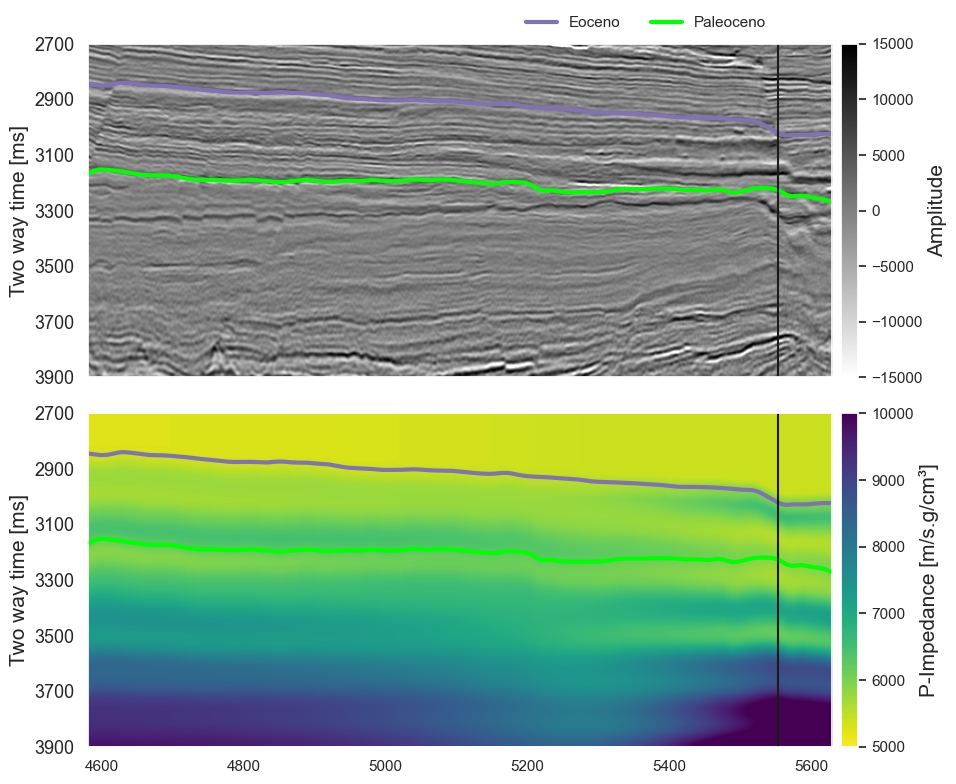

In [3]:
# Seismic section of well 55

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

c = axs[0].imshow(
    amp.T,  # Amplitude
    aspect="auto",
    cmap="gray_r",
    vmin=-15000,
    vmax=15000,
    extent=[xl_start, xl_end, 7000, 0],
)
plt.colorbar(c, ax=axs[0], pad=0.01).set_label("Amplitude", size=15)

c = axs[1].imshow(
    mback.T,  # Impedância de baixa freq.
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=10000,
    extent=[xl_start, xl_end, 7000, 0],
)
plt.colorbar(c, ax=axs[1], pad=0.01).set_label("P-Impedance [m/s.g/cm³]", size=15)


for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3900, 2700)
    # ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3901, 200))
    ax.set_yticklabels(np.arange(2700, 3901, 200), size=13)
    ax.plot(
        eoceno.loc[eoceno.X == 2862].Y,
        eoceno.loc[eoceno.X == 2862].Z,
        color="m",
        lw=3.0,
        label="Eoceno",
    )
    ax.plot(
        paleoceno.loc[paleoceno.X == 2862].Y,
        paleoceno.loc[paleoceno.X == 2862].Z,
        color="lime",
        lw=3.0,
        label="Paleoceno",
    )

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color="k")

axs[0].legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.75, 1.0),
    facecolor="white",
    edgecolor="white",
)
axs[0].set_xticks([])
plt.tight_layout()
# plt.savefig('Figures/lowfrequency_497.png', dpi=200, bbox_inches='tight')

In [4]:
# Convertendo de tempo para profundidade

path = "Pocos/IP_UPS/"

df = pd.DataFrame()
names = [
    "Depth",
    "VP",
    "RHO",
    "VP_4Hz",
    "RHO_4Hz",
    "VP_6Hz",
    "RHO_6Hz",
    "VP_8Hz",
    "RHO_8Hz",
    "IP",
    "IP_4Hz",
    "IP_6Hz",
    "IP_8Hz",
]

for file in os.listdir(path):
    well = pd.read_csv(path + file, delim_whitespace=True, skiprows=1, names=names)

    # Replacing nans. The value 1e30 is a null value.
    well.replace(1e30, np.nan, inplace=True)

    # Naming well
    well["WELL"] = file.split("_")[0]
    time_vs_depth = pd.read_csv(
        f'Pocos/TimeVsDepth/{file.split("_")[0]}.dat',
        skiprows=14,
        delim_whitespace=True,
        names=["MD", "TVD", "TVDSS", "TWT", "VINT"],
    )
    interp_time_vs_depth = scipy.interpolate.interp1d(
        time_vs_depth["MD"],
        time_vs_depth["TWT"],
        fill_value="extrapolate",
        bounds_error=False,
    )
    t_well = interp_time_vs_depth(well.Depth)

    new_samples = np.arange(2700, 3900, 4)
    interp2 = scipy.interpolate.interp1d(
        t_well, well.IP, bounds_error=False, fill_value="extrapolate"
    )
    ip_ups = interp2(new_samples)  # impedance upsampled
    ip_ups = scipy.ndimage.gaussian_filter(ip_ups, sigma=0.5)

    arr = np.array([new_samples, ip_ups])
    nwell = pd.DataFrame(arr.T, columns=["TWT", "IP_UPS"])
    nwell["WELL"] = file.split("_")[0]
    nwell["IP_UPS"] = nwell["IP_UPS"].fillna(method="bfill").fillna(method="ffill")
    # for i in nwell.WELL.unique():
    #     plt.title(i)
    #     plt.plot(nwell[nwell['WELL'] == i]['IP_UPS'])
    #     plt.savefig(f'Figures/{i}.png', dpi=200, bbox_inches='tight')
    #     plt.clf()
    df = pd.concat([df, nwell], ignore_index=True)

--------------------------------------------------------------------------------------------------------------------------

# Inversões

### Normal Equations without regularization

In [5]:
amp_ls = amp.copy()
mback_ls = mback.copy()

In [6]:
# Inverting at well 55 inline
"""
O código está pegando todas as linhas e as colunas de 675 a 974 da matriz `mback_ls`.
"""

amp_ls = amp[:, 675:975].T
mback_ls = np.log(mback[:, 675:975].T)

print("Shape of amp_ls [n_samples, n_traces]:", amp_ls.shape)
print("Shape of mback_ls [n_samples, n_traces]:", mback_ls.shape)

Shape of amp_ls [n_samples, n_traces]: (300, 1051)
Shape of mback_ls [n_samples, n_traces]: (300, 1051)


In [10]:
# Wavelet operator
nz, nx = amp_ls.shape
PPop = pylops.avo.poststack.PoststackLinearModelling(
    wav / 2, nt0=nz, spatdims=nx, explicit=True
)

# Trace-by-trace - y = Op * m
m_inv_tbt, _ = pylops.optimization.leastsquares.normal_equations_inversion(
    Op=PPop,  # operador de modelagem direta (G)
    y=amp_ls.ravel() / 30000,  # dado observado.
    Regs=[],
    epsI=5e-1,  # tikhonov
    x0=mback_ls.ravel(),  # modelo inicial
    engine="scipy",
    **dict(maxiter=1000, show=True)
)
m_inv_tbt = np.exp(mback_ls + m_inv_tbt.reshape(nz, nx))

NormalEquationsInversion
-------------------------------------------------------
The Operator Op has 315300 rows and 315300 cols
Regs=[]
epsRs=[]     epsI=0.5
-------------------------------------------------------


### Regularized Inversion (least squares)

In [8]:
# Second derivative regularization operator
D2op = pylops.SecondDerivative([nz, nx], axis=1, dtype="float64")

In [9]:
# Regularized function
m_inv_reg, _, _, _, _ = pylops.optimization.leastsquares.regularized_inversion(
    Op=PPop,  # operador de modelagem direta (G)
    y=amp_ls.ravel() / 30000,  # dado observado.
    Regs=[D2op],  # regularization operator
    x0=mback_ls.ravel(),  # modelo inicial
    **dict(damp=9e-1, iter_lim=1000, show=0)
)

m_inv_reg = np.exp(m_inv_reg.reshape(nz, nx))

### Fista Inversion

In [10]:
# FFTop = pylops.signalprocessing.FFT(nz*nx)
# Não funcionou

In [24]:
m_inv_fista = pylops.optimization.sparsity.fista(
    PPop, y=amp_ls.ravel() / 30000, x0=mback_ls.ravel(), niter=1000, eps=0.04, tol=1e-5
)[0]
m_inv_fista = np.exp(mback_ls + m_inv_fista.reshape(nz, nx))

In [25]:
m_inv_fista = pylops.optimization.sparsity.fista(
    PPop, y=amp_ls.ravel() / 30000, x0=mback_ls.ravel(), niter=1000, eps=0.04, tol=1e-5
)[0]
m_inv_fista = m_inv_fista.reshape(nz, nx)

### Pre-conditioned inversion

In [12]:
# Create pre-condition operator
Sop = pylops.FirstDerivative(dims=[nz, nx], axis=0, dtype="float64")

# Invert for interpolated signal
m_inv_prec = pylops.optimization.leastsquares.preconditioned_inversion(
    PPop,
    y=amp_ls.ravel() / 30000,
    P=Sop,
    **dict(damp=np.sqrt(1e-1), iter_lim=1000, show=0)
)[0]
m_inv_prec = np.exp(mback_ls + m_inv_prec.reshape(nz, nx))

# PLOTS

## TRACE BY TRACE

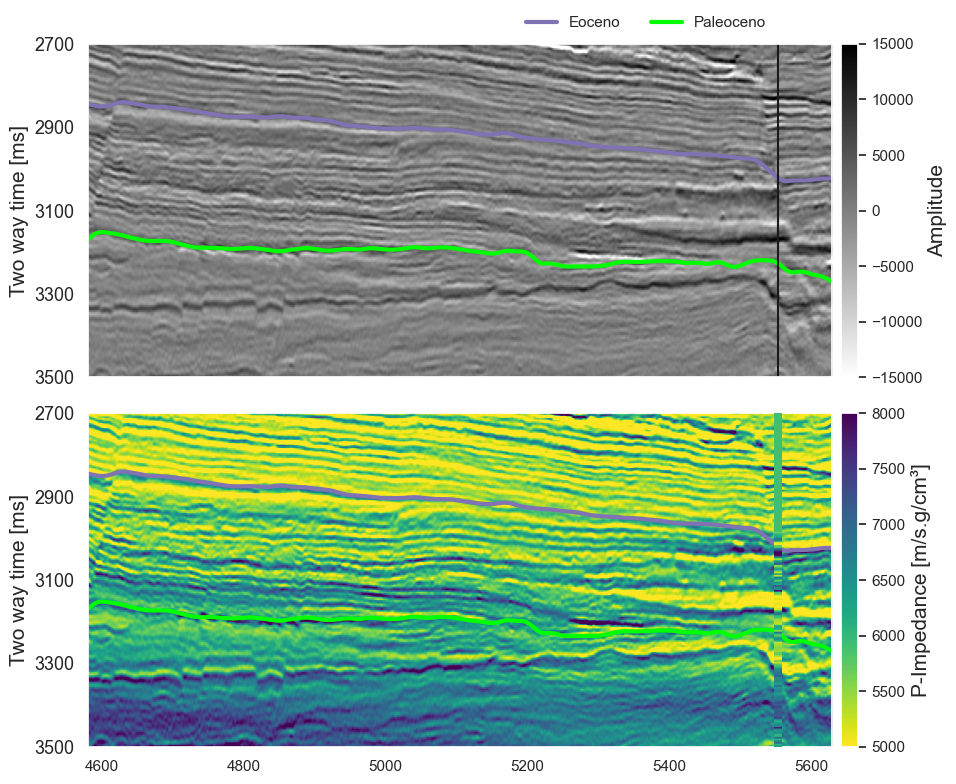

In [12]:
# Seismic section of well 55
img = np.tile(df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS, (100, 1))

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# amplitude
c = axs[0].imshow(
    amp_ls,
    aspect="auto",
    cmap="gray_r",
    vmin=-15000,
    vmax=15000,
    extent=[xl_start, xl_end, 3900, 2700],
)
plt.colorbar(c, ax=axs[0], pad=0.01).set_label("Amplitude", size=15)

# inversion trace-by-trace
c = axs[1].imshow(
    m_inv_tbt,
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=8000,
    extent=[xl_start, xl_end, 3900, 2700],
)
plt.colorbar(c, ax=axs[1], pad=0.01).set_label("P-Impedance [m/s.g/cm³]", size=15)

# well impedance
axs[1].imshow(
    img.T,
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=8000,
    extent=(5553 - 5, 5553 + 5, 3900, 2700),
    zorder=20,
)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3500, 2700)
    # ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(
        eoceno.loc[eoceno.X == 2862].Y,
        eoceno.loc[eoceno.X == 2862].Z,
        color="m",
        lw=3.0,
        label="Eoceno",
    )
    ax.plot(
        paleoceno.loc[paleoceno.X == 2862].Y,
        paleoceno.loc[paleoceno.X == 2862].Z,
        color="lime",
        lw=3.0,
        label="Paleoceno",
    )

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color="k")

axs[0].legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.75, 1.0),
    facecolor="white",
    edgecolor="white",
)
axs[0].set_xticks([])
plt.tight_layout()
plt.savefig("Figures/image_inversion_497_well.png", dpi=200, bbox_inches="tight")

## REGULARIZED

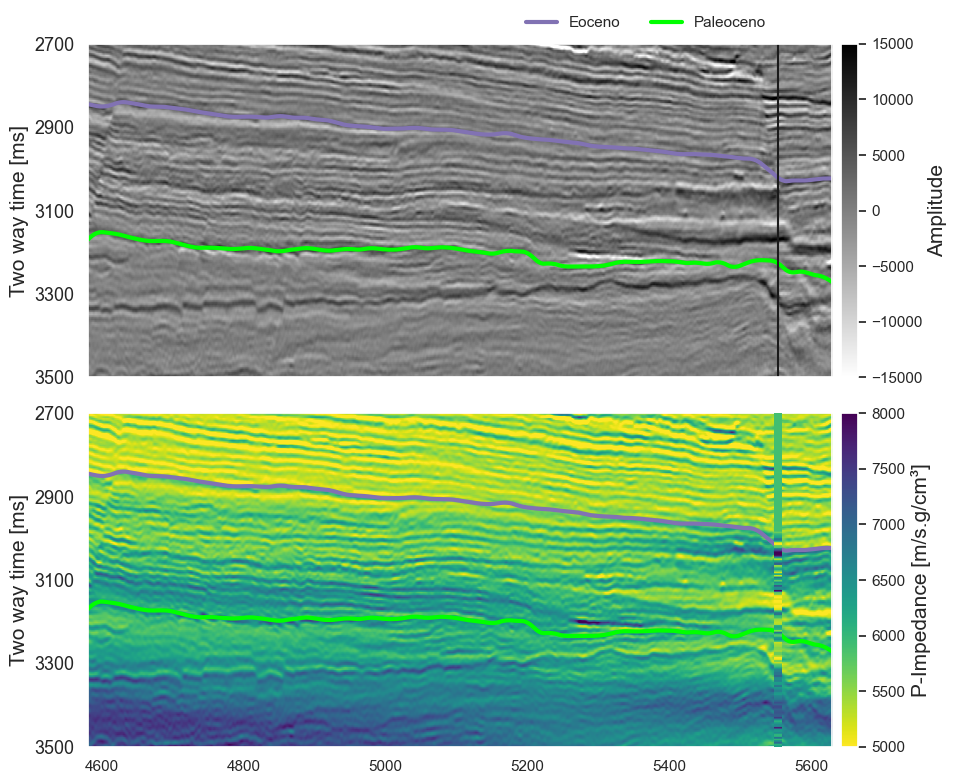

In [13]:
# Seismic section of well 55
img = np.tile(df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS, (100, 1))
fig, axs = plt.subplots(2, 1, figsize=(10, 8))


# amplitude
c = axs[0].imshow(
    amp_ls,
    aspect="auto",
    cmap="gray_r",
    vmin=-15000,
    vmax=15000,
    extent=[xl_start, xl_end, 3900, 2700],
)
plt.colorbar(c, ax=axs[0], pad=0.01).set_label("Amplitude", size=15)

# inversion trace-by-trace
c = axs[1].imshow(
    m_inv_reg,
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=8000,
    extent=[xl_start, xl_end, 3900, 2700],
)
plt.colorbar(c, ax=axs[1], pad=0.01).set_label("P-Impedance [m/s.g/cm³]", size=15)

# well impedance
axs[1].imshow(
    img.T,
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=8000,
    extent=(5553 - 5, 5553 + 5, 3900, 2700),
    zorder=20,
)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3500, 2700)
    # ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(
        eoceno.loc[eoceno.X == 2862].Y,
        eoceno.loc[eoceno.X == 2862].Z,
        color="m",
        lw=3.0,
        label="Eoceno",
    )
    ax.plot(
        paleoceno.loc[paleoceno.X == 2862].Y,
        paleoceno.loc[paleoceno.X == 2862].Z,
        color="lime",
        lw=3.0,
        label="Paleoceno",
    )

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color="k")

axs[0].legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.75, 1.0),
    facecolor="white",
    edgecolor="white",
)
axs[0].set_xticks([])
plt.tight_layout()
plt.savefig(
    "Figures/image_inversion_497_well_regularized.png", dpi=200, bbox_inches="tight"
)

## FISTA

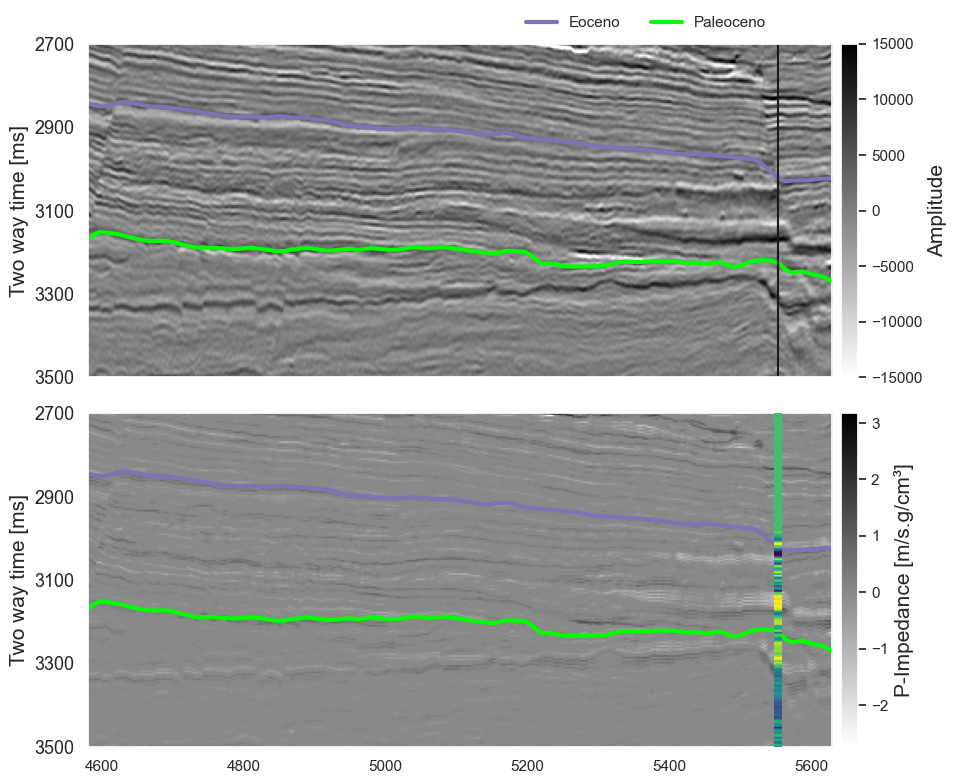

In [21]:
# Seismic section of well 55
img = np.tile(df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS, (100, 1))
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# amplitude
c = axs[0].imshow(
    amp_ls,
    aspect="auto",
    cmap="gray_r",
    vmin=-15000,
    vmax=15000,
    extent=[xl_start, xl_end, 3900, 2700],
)
plt.colorbar(c, ax=axs[0], pad=0.01).set_label("Amplitude", size=15)

# inversion trace-by-trace
c = axs[1].imshow(
    m_inv_fista, aspect="auto", cmap="gray_r", extent=[xl_start, xl_end, 3900, 2700]
)
plt.colorbar(c, ax=axs[1], pad=0.01).set_label("P-Impedance [m/s.g/cm³]", size=15)

# well impedance
axs[1].imshow(
    img.T,
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=8000,
    extent=(5553 - 5, 5553 + 5, 3900, 2700),
    zorder=20,
)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3500, 2700)
    # ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(
        eoceno.loc[eoceno.X == 2862].Y,
        eoceno.loc[eoceno.X == 2862].Z,
        color="m",
        lw=3.0,
        label="Eoceno",
    )
    ax.plot(
        paleoceno.loc[paleoceno.X == 2862].Y,
        paleoceno.loc[paleoceno.X == 2862].Z,
        color="lime",
        lw=3.0,
        label="Paleoceno",
    )

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color="k")

axs[0].legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.75, 1.0),
    facecolor="white",
    edgecolor="white",
)
axs[0].set_xticks([])
plt.tight_layout()
plt.savefig("Figures/image_inversion_497_well_fista.png", dpi=200, bbox_inches="tight")

## PREC

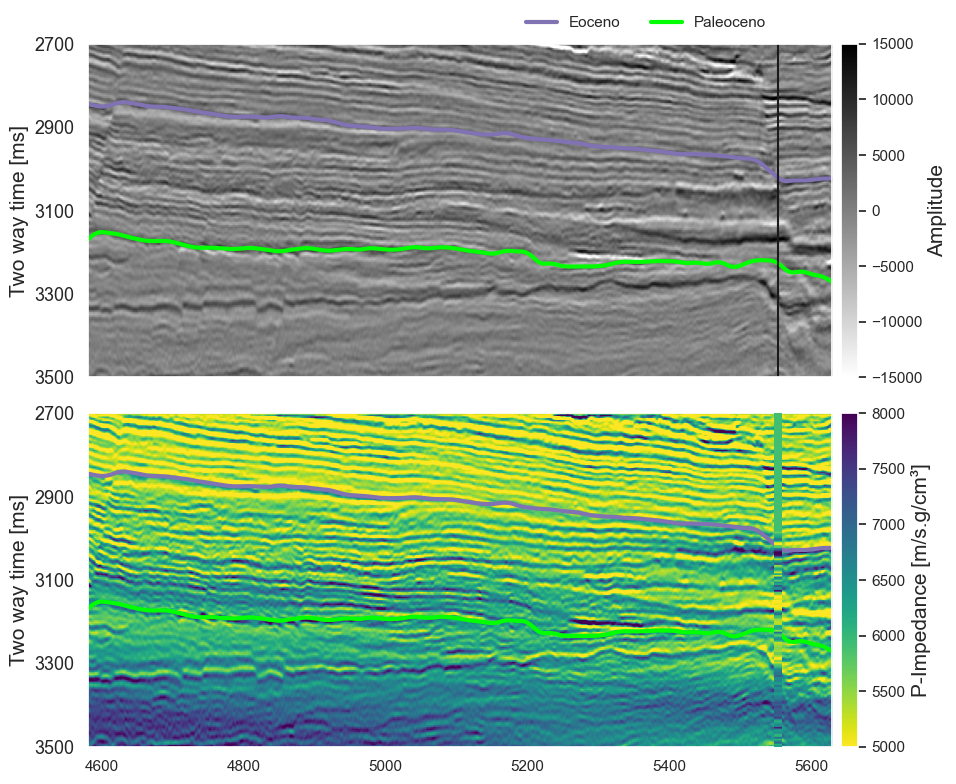

In [15]:
# Seismic section of well 55
img = np.tile(df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS, (100, 1))
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# amplitude
c = axs[0].imshow(
    amp_ls,
    aspect="auto",
    cmap="gray_r",
    vmin=-15000,
    vmax=15000,
    extent=[xl_start, xl_end, 3900, 2700],
)
plt.colorbar(c, ax=axs[0], pad=0.01).set_label("Amplitude", size=15)

# inversion trace-by-trace
c = axs[1].imshow(
    m_inv_prec,
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=8000,
    extent=[xl_start, xl_end, 3900, 2700],
)
plt.colorbar(c, ax=axs[1], pad=0.01).set_label("P-Impedance [m/s.g/cm³]", size=15)

# well impedance
axs[1].imshow(
    img.T,
    aspect="auto",
    cmap="viridis_r",
    vmin=5000,
    vmax=8000,
    extent=(5553 - 5, 5553 + 5, 3900, 2700),
    zorder=20,
)

for ax in [axs[0], axs[1]]:
    ax.grid(False)
    ax.set_ylim(3500, 2700)
    # ax.set_xlim(il_start, il_end)
    ax.set_yticks(np.arange(2700, 3501, 200))
    ax.set_yticklabels(np.arange(2700, 3501, 200), size=13)
    ax.plot(
        eoceno.loc[eoceno.X == 2862].Y,
        eoceno.loc[eoceno.X == 2862].Z,
        color="m",
        lw=3.0,
        label="Eoceno",
    )
    ax.plot(
        paleoceno.loc[paleoceno.X == 2862].Y,
        paleoceno.loc[paleoceno.X == 2862].Z,
        color="lime",
        lw=3.0,
        label="Paleoceno",
    )

    ax.set_ylabel("Two way time [ms]", fontsize=15)

    ax.axvline(x=5553, color="k")

axs[0].legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.75, 1.0),
    facecolor="white",
    edgecolor="white",
)
axs[0].set_xticks([])
plt.tight_layout()
plt.savefig("Figures/image_inversion_497_well_prec.png", dpi=200, bbox_inches="tight")

## Comparação

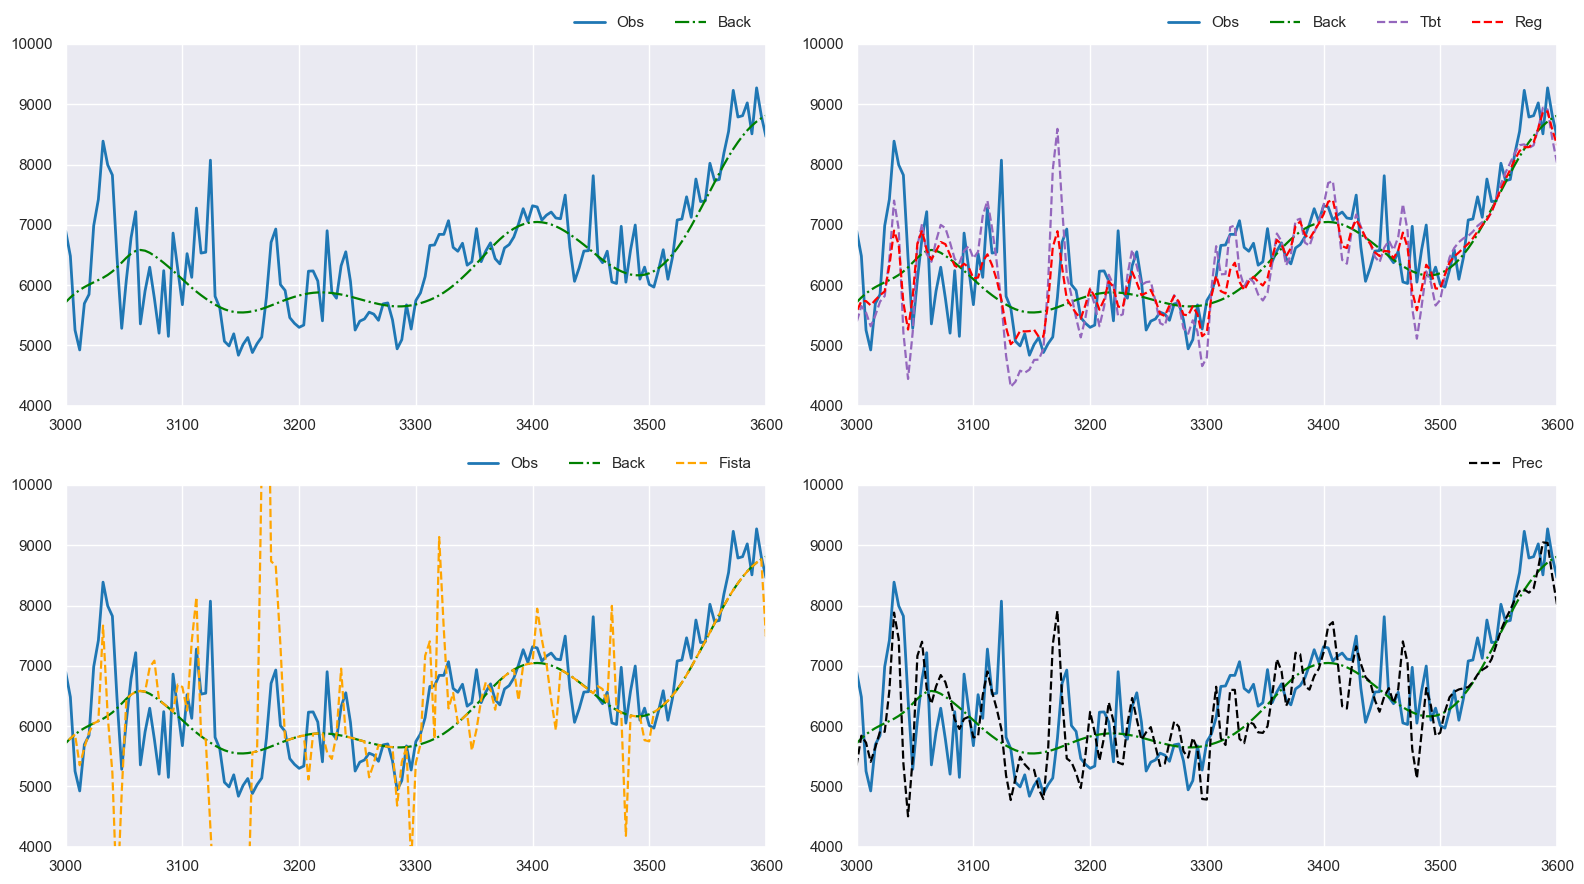

In [16]:
x_axis = df.loc[df.WELL == "6-BRSA-497-ESS"].TWT
plt.figure(figsize=(16, 9))

plt.subplot(221)
plt.plot(
    x_axis,
    df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS,
    label="Obs",
    lw=2.0,
    color="tab:blue",
)
plt.plot(
    x_axis,
    np.exp(mback_ls[:, 5553 - xl_start]),
    label="Back",
    lw=1.6,
    ls="-.",
    color="green",
)
plt.xlim(3000, 3600)
plt.ylim(4000, 10000)

plt.legend(
    loc="lower right", bbox_to_anchor=(1.0, 1.0), edgecolor="w", facecolor="w", ncol=5
)
plt.subplot(222)
plt.plot(
    x_axis,
    df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS,
    label="Obs",
    lw=2.0,
    color="tab:blue",
)
plt.plot(
    x_axis,
    np.exp(mback_ls[:, 5553 - xl_start]),
    label="Back",
    lw=1.6,
    ls="-.",
    color="green",
)
plt.plot(
    x_axis,
    m_inv_tbt[:, 5553 - xl_start],
    label="Tbt",
    lw=1.6,
    ls="--",
    color="tab:purple",
)
plt.plot(
    x_axis, m_inv_reg[:, 5553 - xl_start], label="Reg", lw=1.6, ls="--", color="red"
)

plt.xlim(3000, 3600)
plt.ylim(4000, 10000)

plt.legend(
    loc="lower right", bbox_to_anchor=(1.0, 1.0), edgecolor="w", facecolor="w", ncol=5
)
plt.subplot(223)
plt.plot(
    x_axis,
    df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS,
    label="Obs",
    lw=2.0,
    color="tab:blue",
)
plt.plot(
    x_axis,
    np.exp(mback_ls[:, 5553 - xl_start]),
    label="Back",
    lw=1.6,
    ls="-.",
    color="green",
)
plt.plot(
    x_axis,
    m_inv_fista[:, 5553 - xl_start],
    label="Fista",
    lw=1.6,
    ls="--",
    color="orange",
)


plt.xlim(3000, 3600)
plt.ylim(4000, 10000)

plt.legend(
    loc="lower right", bbox_to_anchor=(1.0, 1.0), edgecolor="w", facecolor="w", ncol=5
)
plt.subplot(224)
plt.plot(x_axis, df.loc[df.WELL == "6-BRSA-497-ESS"].IP_UPS, lw=2.0, color="tab:blue")
plt.plot(x_axis, np.exp(mback_ls[:, 5553 - xl_start]), lw=1.6, ls="-.", color="green")
plt.plot(
    x_axis, m_inv_prec[:, 5553 - xl_start], label="Prec", lw=1.6, ls="--", color="black"
)

plt.xlim(3000, 3600)
plt.ylim(4000, 10000)

plt.tight_layout()
plt.legend(
    loc="lower right", bbox_to_anchor=(1.0, 1.0), edgecolor="w", facecolor="w", ncol=5
)

plt.savefig("Figures/all_comparison_plots.png", dpi=200, bbox_inches="tight")

-----------------------------------------------------------------------------------------------------------------------